# Project

## 1. Imports

Run this first cell to install all the necessary dependencies for this project when first running the project. Afterwards you can comment it out.

In [1]:
#!pip install ./requirements.txt
#!pip install ./nceiDatabaseConnector/dist/nceiDatabaseConnector-0.1.0-py3-none-any.whl


In [2]:
#use the top two rows if you don't have the package installed, otherwise the other two
from nceiDatabaseConnector.nceiDatabasePackage.nceiDatabaseManager import NCEIDatabaseManager
from nceiDatabaseConnector.nceiDatabasePackage.nceiDataManager import NCEIDataManager
#from nceiDatabasePackage import NCEIDatabaseManager
#from nceiDatabasePackage import NCEIDataManager


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import folium

## 2. User settings

- years_in_db: An array of year Numbers that we want to download
- stations_file_path: the path where the stations data is stored and located
- modified_stations_file_path: the path where the modified stations data is stored
- download_csv_file_path: where the csv.gz files from the ncei file server should be saved
- modified_csv_file_path: where the modified csv files should be saved
- db_name: the name of the database you want to connect to
- db_user: the user that you want to connect with to the database
- db_password: the password for the user
- debug_messages: set this to true if you want to see the debug messages
- station_cols: the attributes of the station file
- weather_cols: the attributes of the weather data

In [3]:
years_in_db = [1950, 1951, 1952, 1953, 1954, 2010, 2011, 2012, 2013, 2014]
stations_file_path = "./data/stations/"
modified_stations_file_path = "./data/stations/modifiedStations/"
download_csv_file_path = "./data/NCEI/ghcn/daily/"
modified_csv_file_path = "./data/NCEI/modified/daily/"
db_name = "NCEIDatabase"
db_user = "ESDP"
db_password = "esdp1"
debug_messages = False
station_cols = ["id", "latitude", "longitude", "elevation", "state", "name", "gsn_flag", "hcn_crn_flag", "wmo_id"]
weather_cols = ["id", "stationcode", "datelabel", "param", "value", "mflag", "qflag", "sflag", "time"]

### 2.1 Docker setup

In [4]:
#This command writes the db_name, db_user and db_password to an env file which is used by the docker-container during postgresql setup (normally this should not be done within the jupyter notebook as it exposes the db_name, db_user and db_password.
envVariables = {
    "DATABASE_NAME": db_name,
    "DATABASE_USER": db_user,
    "DATABASE_PASSWORD": db_password,
}

with open(".env", "w") as env_file:
    for key, value in envVariables.items():
        env_file.write(f"{key}={value}\n")

print(".env file created successfully.")

.env file created successfully.


#### Docker compose statements
If it's the first time setting up the database, make sure to run ```!docker-compose up -d --build``` in your terminal.
If your docker-container already exists you should use the command ```!docker-compose up -d``` instead.

In [5]:
#!docker-compose up -d --build
!docker-compose up -d

time="2024-07-18T07:42:29+02:00" level=warning msg="c:\\Users\\Fabi\\dev\\python\\ESDP1-Database-Project\\docker-compose.yml: `version` is obsolete"
 Container esdp1-database-project-db-1  Running


In [6]:
# run this to stop the docker container (but keep the data in the database for later)
# !docker-compose stop
# run this to stop and remove the docker container (you will loose all the data within the database and will have to set it up again)
#!docker-compose down

## 3. Create database manager

In [7]:
#create one instance of the NCEIDatabaseManager with the passed parameters
ncei_db = NCEIDatabaseManager(db_name=db_name, 
                         db_user=db_user, 
                         db_password=db_password, 
                         db_host="localhost", 
                         db_port="5432",
                         debug_messages = True,
                         years_in_db = years_in_db)

In [8]:
# show all functions of the instance
print(dir(ncei_db))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'check_year', 'connect_to_db', 'count_rows', 'create_climate_table', 'create_climate_tables', 'create_stations_table', 'db_host', 'db_name', 'db_password', 'db_port', 'db_user', 'debug_messages', 'drop_table', 'get_data_between_dates', 'get_data_between_dates_one_year', 'get_data_by_station_param', 'get_data_yearly', 'get_month_data', 'get_station_data', 'get_station_data_by_stationcode', 'insert_copy', 'is_valid_year', 'is_year_in_db', 'multi_threaded_insert', 'split_csv_file', 'station_cols', 'weather_cols', 'years_in_db']


## 4. Create data manager

In [9]:
#create one instance of the NCEIDataManager
ncei_data = NCEIDataManager()

In [10]:
# show all functions of the instance
print(dir(ncei_data))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'convert_stations', 'download_stations', 'download_year', 'download_years', 'export_downloaded_year', 'export_downloaded_years']


## 5. Download Data

### 5.1 Download Stations

In [11]:
#download the station data file and the station readme file and store them
ncei_data.download_stations(file_path_dest=stations_file_path)


Already downloaded station data.
Already downloaded station readme file.
Data (stations and readme) downloaded and saved in ./data/stations/


### 5.2 Download Climate data

In [12]:
#download the daily data based on the parameters, enable/disable multi_thread as you wish 
ncei_data.download_years(array_of_years=years_in_db,
                         file_path=download_csv_file_path,
                         multi_thread=True, 
                         num_threads=4)

Already downloaded data for year 1950
Already downloaded data for year 1951
Already downloaded data for year 1953
Already downloaded data for year 1952
Already downloaded data for year 1954
Already downloaded data for year 2010
Already downloaded data for year 2011
Already downloaded data for year 2013
Already downloaded data for year 2012
Already downloaded data for year 2014


## 6. Export Filtered Data

In [13]:
#preprocessing loads downloaded the data into a dataframe, filters it and applies scaling factors etc. After that is saves the filtered data into the modified_csv_file_path
ncei_data.export_downloaded_years(array_of_years=years_in_db, 
                                  file_path=download_csv_file_path, 
                                  file_path_dest=modified_csv_file_path, 
                                  multi_thread=True, 
                                  num_threads=4)

...Year 1950 processing...
...Year 1951 processing...
...Year 1952 processing...
Already exported data for year 1952.
...Year 1953 processing...
Already exported data for year 1951.
Already exported data for year 1950.
Already exported data for year 1953.
...Year 1954 processing...
...Year 2010 processing...
...Year 2011 processing...
...Year 2012 processing...
Already exported data for year 1954.
...Year 2013 processing...
Already exported data for year 2013.
...Year 2014 processing...
Already exported data for year 2012.
Already exported data for year 2014.
Already exported data for year 2010.
Already exported data for year 2011.


## 7. Fill Database

### 7.1 Stations

#### 7.1.1 Drop station table

In [14]:
#drop the station database
# ncei_db.drop_table("Station")

#### 7.1.2 Create the stations table

In [15]:
#creates the "station" table in the SQL database if it not exists already
ncei_db.create_stations_table()

Connected to database NCEIDatabase with user ESDP
Station table created.
Disconnected


#### 7.1.3 Insert the station into the database

In [16]:
#preprocessing of the station data: renaming of columns etc done before storing the dataframe to the database
ncei_data.convert_stations(stations_file_path, modified_stations_file_path)

Saved the modified stations file to ./data/stations/modifiedStations//modified_stations.csv


In [17]:
#insertion of the station data with the postgre COPY statment
ncei_db.insert_copy(file_path = f"{modified_stations_file_path}modified_stations.csv", table_name="Station", columns=station_cols)

Connected to database NCEIDatabase with user ESDP
Copying file ./data/stations/modifiedStations/modified_stations.csv to database Station
Error: duplicate key value violates unique constraint "Station_pkey"
DETAIL:  Key (id)=(ACW00011604) already exists.
CONTEXT:  COPY Station, line 2

Disconnected


#### 7.1.4 Verify the data insertion

In [18]:
#verfiy that the data is inserted in the database by checking the rows
ncei_db.count_rows("Station")

Connected to database NCEIDatabase with user ESDP
The table Station contains 127994 rows.
Disconnected


127994

### 7.2 Climate tables

#### 7.2.1 Drop table

In [19]:
# ncei_db.drop_table("Climate1950")

#### 7.2.3 Create all tables

In [20]:
#create all database tables that are in the years_in_db array 
ncei_db.create_climate_tables(years=years_in_db)

Connected to database NCEIDatabase with user ESDP
Table Climate1950 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate1951 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate1952 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate1953 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate1954 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate2010 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate2011 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate2012 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate2013 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate2014 creat

True

#### 7.2.4 Verify the insertion of all tables

In [21]:
#check whether the database tables have data
for year in years_in_db:
    ncei_db.count_rows(f"Climate{year}")

Connected to database NCEIDatabase with user ESDP
The table Climate1950 contains 18503793 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1951 contains 19279848 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1952 contains 19548958 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1953 contains 19831198 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1954 contains 20216183 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate2010 contains 27593925 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate2011 contains 26132221 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate2012 contains 26050070 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate2013 contains 25090492 rows.
Disconnected
Connected to databa

#### 7.2.5 Insert the data into the database

In [22]:
#insertion of the climate data into the database
for year in years_in_db:
    filePath = f"{modified_csv_file_path}modified_{year}.csv"

    #either creates the database table if it has not existed yet or creates a new table 
    #returns the table name either way
    table_name = ncei_db.create_climate_table(year=year)
    
    #use of multi-thread function that uses the postgre COPY statement
    ncei_db.multi_threaded_insert(file_path=filePath, 
                                  table_name=table_name, 
                                  columns=weather_cols, 
                                  num_threads=4)

Connected to database NCEIDatabase with user ESDP
Table Climate1950 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1950 contains 18503793 rows.
Disconnected
Data in table Climate1950 already exists. Please check or delete the database before continuing.
Connected to database NCEIDatabase with user ESDP
Table Climate1951 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1951 contains 19279848 rows.
Disconnected
Data in table Climate1951 already exists. Please check or delete the database before continuing.
Connected to database NCEIDatabase with user ESDP
Table Climate1952 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1952 contains 19548958 rows.
Disconnected
Data in table Climate1952 already exists. Please check or delete the database before continuing.
Connected to database NCEIDatabase with user ESDP
Table Climate1953 creat

## 8. Get Data

We want to compare different parameters for the years 1950-1954 and 2010-2014.  
We have the parameters TMIN, TMAX, PRCP etc.

1. Create lineplot for a yearly daterange resulting in yearly comparison
2. Create boxplot for a monthy comparison of different years 
3. Create simple geographical plots use of station data and aggregated values

*Selection of stations for getting and plotting data*
- in the first step, we tried to find stations that have the most data in the years 1950 and 2010 and use these stations 
  - SELECT COUNT(*) AS count, stationcode FROM "Climate1950" GROUP BY stationcode ORDER BY count DESC LIMIT 1;
  - Result: AUW00034165
  - SELECT COUNT(*) AS count, stationcode FROM "Climate2010" GROUP BY stationcode ORDER BY count DESC LIMIT 1;
  - Result: AQW00061705
- But the result was that the first station only had data in 1950 and the other only had data of 2010
- Then we delimited the queries and tried some stations that had many entries in both years
- Result: CA001012040 und CA001016940
- later we added two more stations to get interesting insights from other continents and other aspects like elevation etc. ()
- ['CA001012040' 48.8167 -124.1333 177.0 'BC' 'COWICHAN LAKE FORESTRY' None None None]
- ['CA001016940' 48.6167 -123.4167 61.0 'BC' 'SAANICHTON CDA' None None None]
- ['ASN00008051' -28.7953 114.6975 33.0 None 'GERALDTON AIRPORT' 'GSN' None '94403']
- ['CHM00055279' 31.367 90.017 4701.0 None 'BAINGOIN' None None '55279'] 

### 8.1 Station data

In [23]:
#get all data from the station table
stations_data = ncei_db.get_station_data(columns=station_cols)
stations_data.head()

Connected to database NCEIDatabase with user ESDP

                    SELECT "id", "latitude", "longitude", "elevation", "state", "name", "gsn_flag", "hcn_crn_flag", "wmo_id" 
                    FROM "Station"               
            
The requested query returned 127994 results.
Alles gucci bis her


,id,latitude,longitude,elevation,state,name,gsn_flag,hcn_crn_flag,wmo_id
0,ACW00011604,17.1167,-61.7833,10.1,None,ST JOHNS COOLIDGE FLD,None,None,None
1,ACW00011647,17.1333,-61.7833,19.2,None,ST JOHNS,None,None,None
2,AE000041196,25.3330,55.5170,34.0,None,SHARJAH INTER. AIRP,GSN,None,41196
3,AEM00041194,25.2550,55.3640,10.4,None,DUBAI INTL,None,None,41194
4,AEM00041217,24.4330,54.6510,26.8,None,ABU DHABI INTL,None,None,41217


In [24]:
#helper function the get the station information of on station 
def get_station_by_stationcode(stationcode):
    return stations_data[stations_data["id"] == stationcode]

#### 8.1.1 Settings

In [25]:
# settomg of the date range to compare different years used in the lineplot
start_date_plotting = "1954-01-01"
end_date_plotting = "2010-12-31"

# setting of the parameters that should be visualized in the lineplot and the boxplot 
parameters = ["PRCP", "TMAX"]

# stations = ["AQW00061705", "AUW00034165"]
# setting of the stations that should be compared
stations = ["CA001012040", "CA001016940", "ASN00008051", "CHM00055279"]

# setting for the data columns that should be retrieved on every station request
columns = ["stationcode", "datelabel", "value", "param"]

# setting for the comparison of yearly plots 
years_for_plotting = [1950, 2012, 2014]

# setting for the boxplot comparison of one month
month = 12

In [26]:
# get insight of station data
for station in stations:
    print(get_station_by_stationcode(station).values[0])

['CA001012040' 48.8167 -124.1333 177.0 'BC' 'COWICHAN LAKE FORESTRY' None
 None None]
['CA001016940' 48.6167 -123.4167 61.0 'BC' 'SAANICHTON CDA' None None None]
['ASN00008051' -28.7953 114.6975 33.0 None 'GERALDTON AIRPORT' 'GSN' None
 '94403']
['CHM00055279' 31.367 90.017 4701.0 None 'BAINGOIN' None None '55279']


### 8.2 Climate data

#### 8.2.2 Get data for lineplot

In [27]:
#gets all the yearly data for all passed parameters and stations
yearly_data_for_lineplot = ncei_db.get_data_yearly(years=years_for_plotting, 
                                                   parameters=parameters, 
                                                   stations=stations, 
                                                   columns=columns)



Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP','TMAX')
                    ORDER BY datelabel                
            
The requested query returned 2190 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP','TMAX')
                    ORDER BY datelabel                
            
The requested query returned 25

In [28]:
#show some data insights
print(yearly_data_for_lineplot.head())
print(yearly_data_for_lineplot.info())

   stationcode   datelabel      value param
0  CA001016940  1950-01-01  -0.600000  TMAX
1  ASN00008051  1950-01-01  43.200000  TMAX
2  ASN00008051  1950-01-01   0.000000  PRCP
3  CA001012040  1950-01-01  -2.200000  TMAX
4  CA001012040  1950-01-01   8.900001  PRCP
<class 'pandas.core.frame.DataFrame'>
Index: 7261 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   stationcode  7261 non-null   object 
 1   datelabel    7261 non-null   object 
 2   value        7261 non-null   float64
 3   param        7261 non-null   object 
dtypes: float64(1), object(3)
memory usage: 283.6+ KB
None


#### 8.2.3 Get data for boxplots

In [29]:
#gets all the monthly data for all passed parameters and stations
for year in years_for_plotting:
    monthly_data = ncei_db.get_month_data(year, month, parameters, stations, columns=columns)

    # get some insights of the data
    print(monthly_data.head())
    print(monthly_data.info())

Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP','TMAX') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 186 results.
   stationcode   datelabel  value param
0  ASN00008051  1950-12-01   38.4  TMAX
1  ASN00008051  1950-12-01    0.0  PRCP
2  CA001012040  1950-12-01    2.8  TMAX
3  CA001012040  1950-12-01    3.8  PRCP
4  CA001016940  1950-12-01    4.4  TMAX
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   stationcode  186 non-null    object 
 1   datelabel    186 non-null   

## 9. Plot Data

We want to compare different parameters for the years 1950-1954 and 2010-2014.  
We have the parameters TMIN, TMAX, PRCP etc.

1. Create lineplot for a yearly daterange resulting in yearly comparison
2. Create boxplot for a monthy comparison of different years 
3. Create simple geographical plots use of station data and aggregated values

### 9.1 Task 1 (Lineplot)

#### 9.1.1 Functions for plotting

In [30]:
def create_linepplot_years(years, stations, parameters, columns = ["stationcode", "datelabel", "value", "param"]):
    # data retrieval
    yearly_data = ncei_db.get_data_yearly(years, parameters, stations, columns)

    # conversion so we can use time functions on the datelabel column
    yearly_data["datelabel"] = pd.to_datetime(yearly_data["datelabel"])

    #iterate over all stations
    for station in stations:
        #filter data to get only station relevant data
        station_filtered_data = yearly_data[(yearly_data["stationcode"] == station)].copy()

        #get the station name for later display
        station_name = get_station_by_stationcode(station)["name"].values[0]

        for parameter in parameters:
            plt.figure(figsize=(14, 8)) 

            #filter data even more to get only parametere relevant data
            parameter_filtered_data = station_filtered_data[(station_filtered_data["param"] == parameter)].copy()

            #check the years array if the years are really in the database and can be accessed
            filtered_years = [year for year in years if ncei_db.check_year(year)]

            for year in filtered_years:
                #filter data even more to get only yearly relevant data
                filtered_data = parameter_filtered_data[(parameter_filtered_data["datelabel"].dt.year == year)].copy()


                if filtered_data.empty:
                    print("Empty")
                    continue

                #this column is important for the overlay of different years on top of each other for better comparison
                filtered_data.loc[:, "day"] = filtered_data.loc[:, "datelabel"].dt.strftime("%m-%d")

                sns.lineplot(x="day", y="value", style=year, data=filtered_data, errorbar=("ci", 1))

            #used for the x-axis ticks
            month_labels = [f"{i:02d}-01" for i in range(1, 13)]
            plt.xticks(ticks=month_labels, labels=pd.to_datetime(month_labels, format="%m-%d").strftime("%b"))
            plt.ylim(parameter_filtered_data["value"].min()-5, parameter_filtered_data["value"].max()+5)
            plt.title(f"Yearly comparison of parameter: {parameter} at station: {station_name}")
            plt.xlabel("Date")
            plt.ylabel(f"{parameter}")
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()

In [31]:
def create_boxplot_monthly_comparison(years, month, stations, parameters, columns = ["stationcode", "datelabel", "value", "param"]):
    for station in stations:
        fig, axes = plt.subplots(len(parameters), len(years), figsize=(15, 10), sharey="row")

        #get the station name for later display
        station_name = get_station_by_stationcode(station)["name"].values[0]
        
        if len(parameters) == 1:
            axes = np.array([axes])

        for i, parameter in enumerate(parameters):
            for j, year in enumerate(years):
                ax = axes[i, j]

                # data retrieval
                monthly_data = ncei_db.get_month_data(year, month, parameters=[parameter], stations=[station], columns=columns)

                #plot display only if data not empty
                if not monthly_data.empty:
                    sns.boxplot(x="stationcode", y="value", data=monthly_data, ax=ax, hue="param", dodge=True)

                    # Set plot labels and title
                    ax.set_title(f"{parameter} | {year}-{month} | {len(monthly_data)} values in DB")
                    ax.set_xlabel("Station Code")
                    ax.set_ylabel(f"Value of parameter {parameter}")
                    ax.set_ylim(monthly_data["value"].min()-2, monthly_data["value"].max()+2)
                    ax.grid()

        plt.suptitle(f"Comparison of station {station_name} through multiple years.")
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.96])  

        # Show plot
        plt.show()



#### 9.1.2 Plot the data

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP','TMAX')
                    ORDER BY datelabel                
            
The requested query returned 2190 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP','TMAX')
                    ORDER BY datelabel                
            
The requested query returned 25

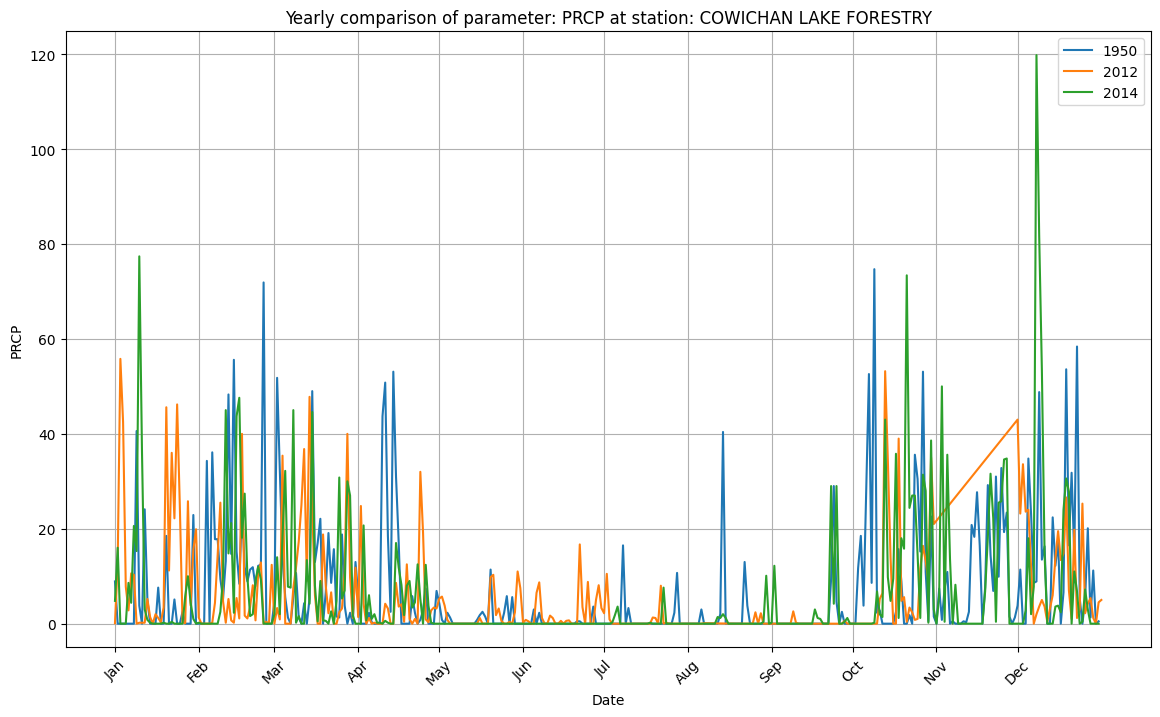

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP


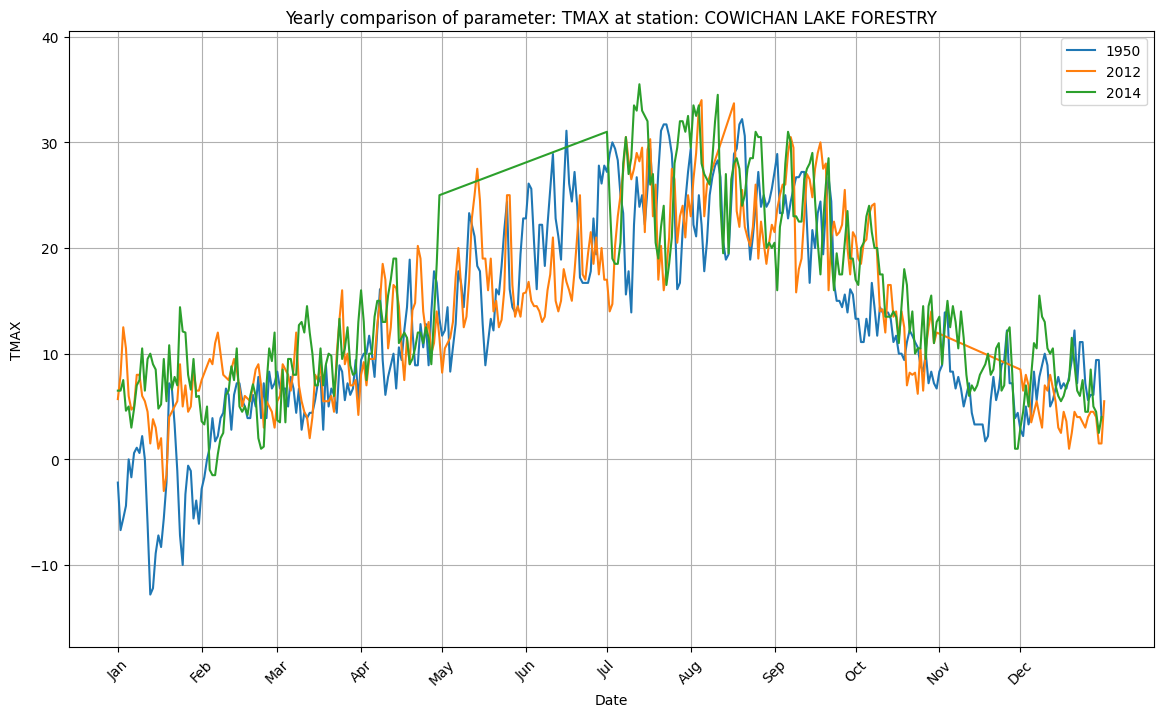

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP


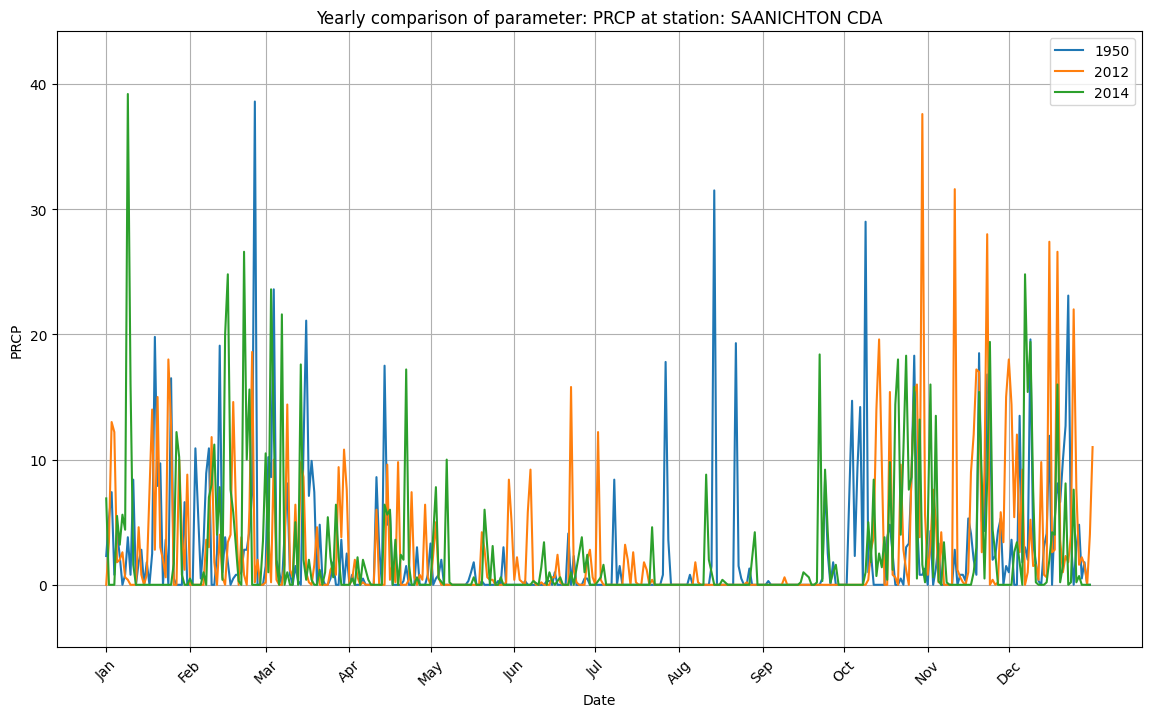

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP


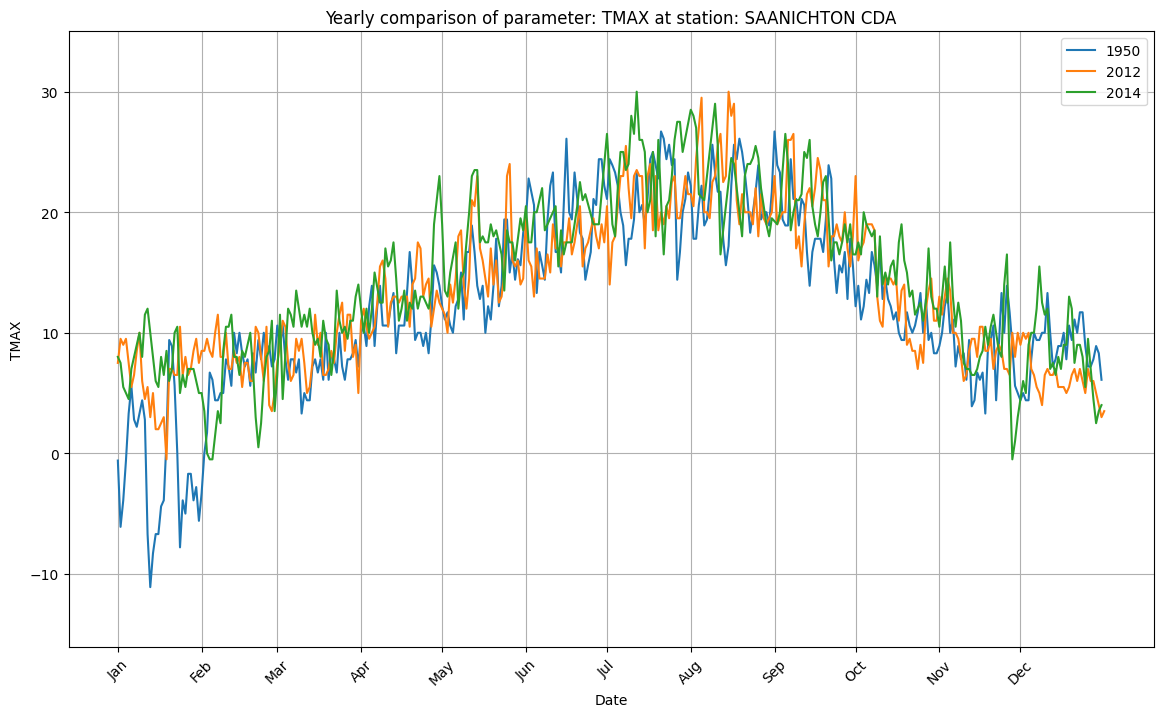

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP


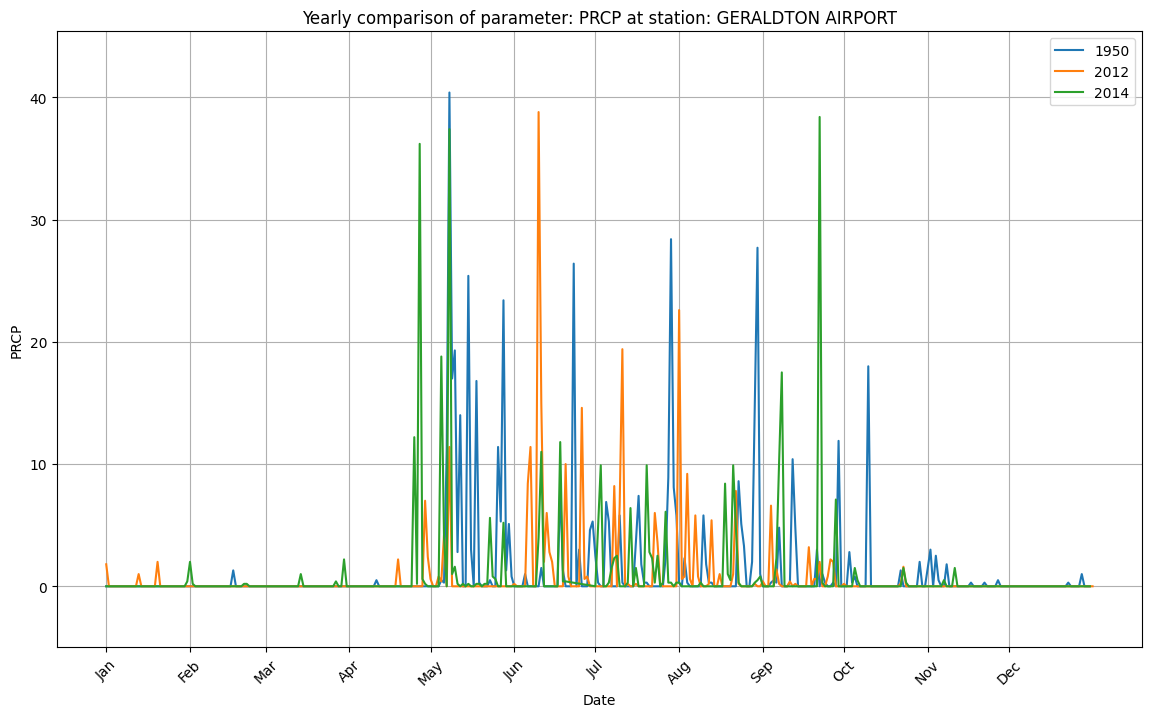

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP


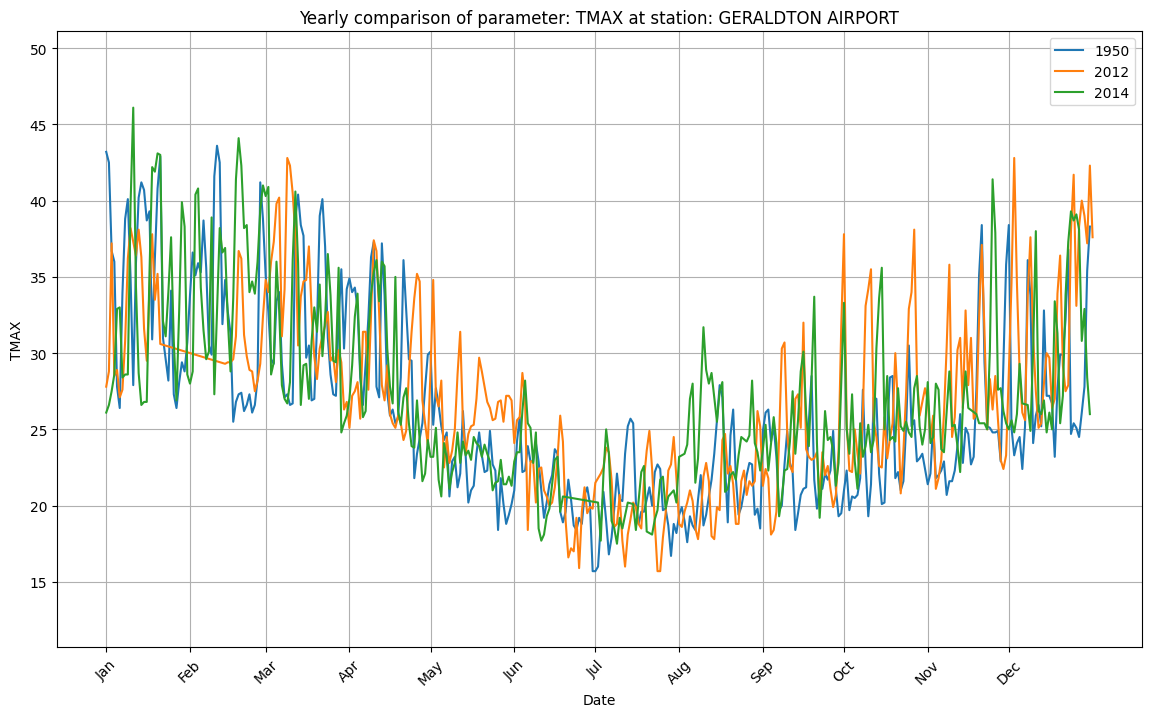

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Empty


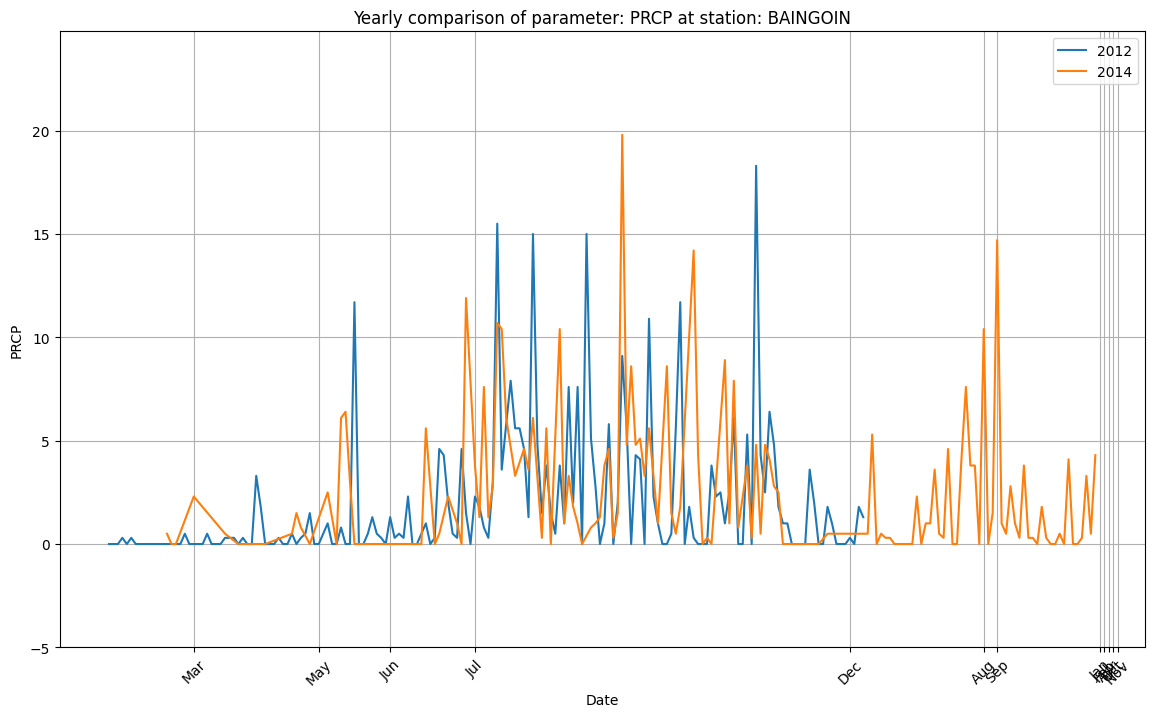

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Empty


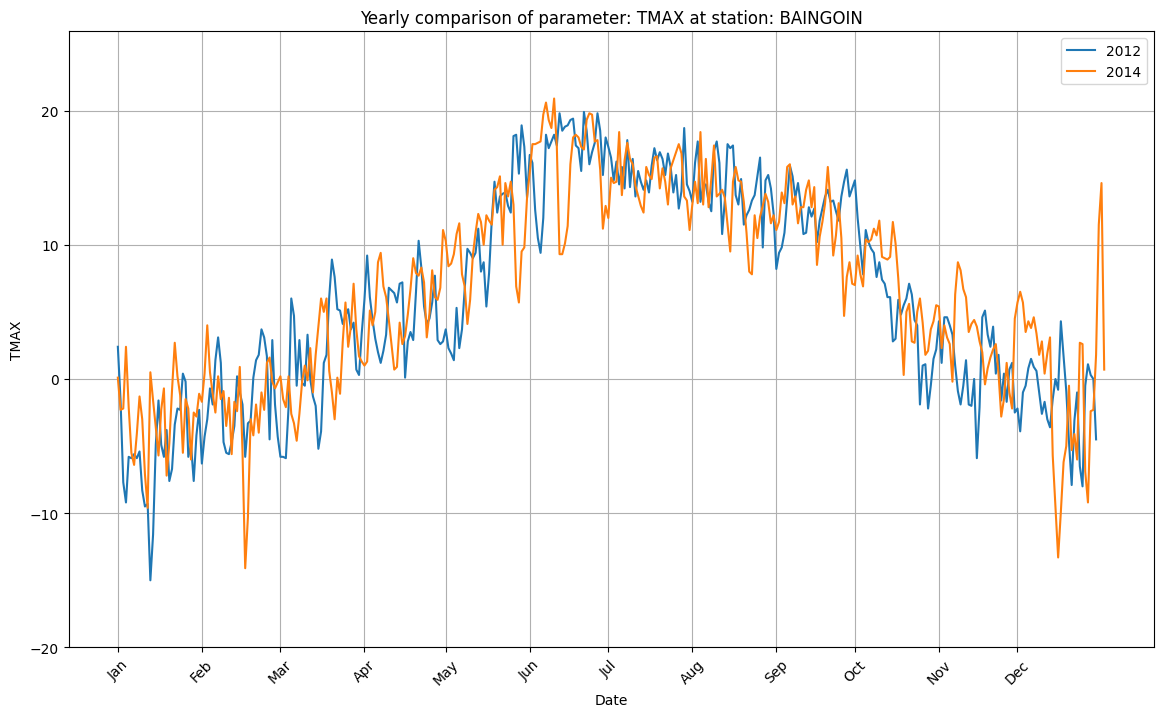

In [32]:
# display of the lineplots to compare different years
create_linepplot_years(years_for_plotting, stations, parameters)

#### 9.1.3 Plot Monthly difference

Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001012040') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 31 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('CA001012040') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 29 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", 

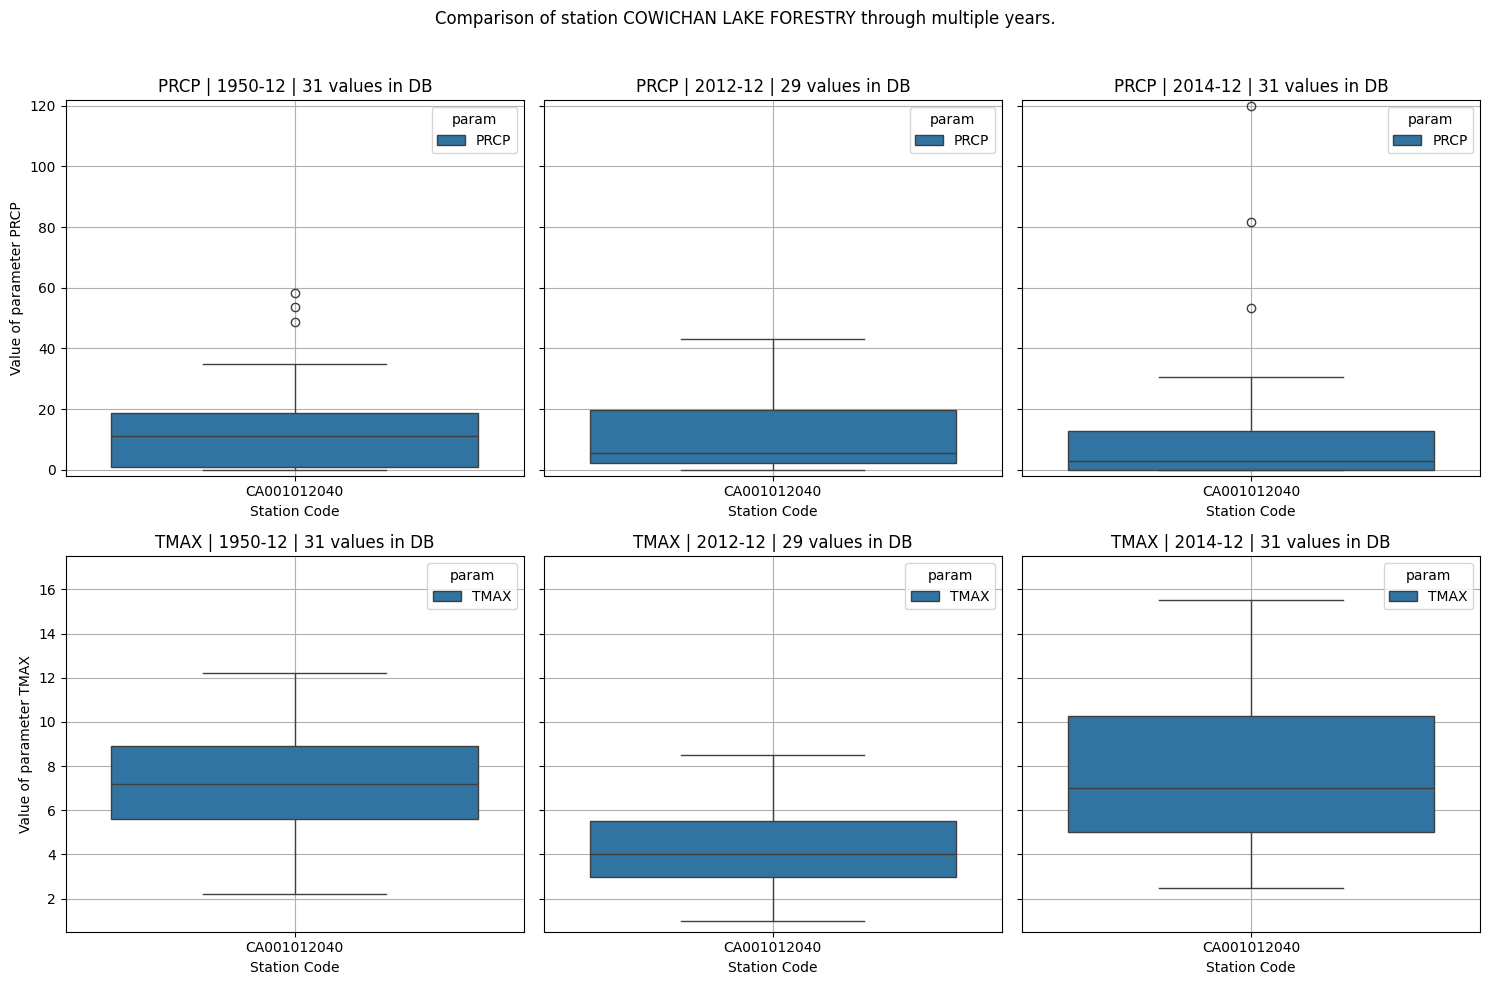

Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001016940') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 31 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('CA001016940') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 31 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", 

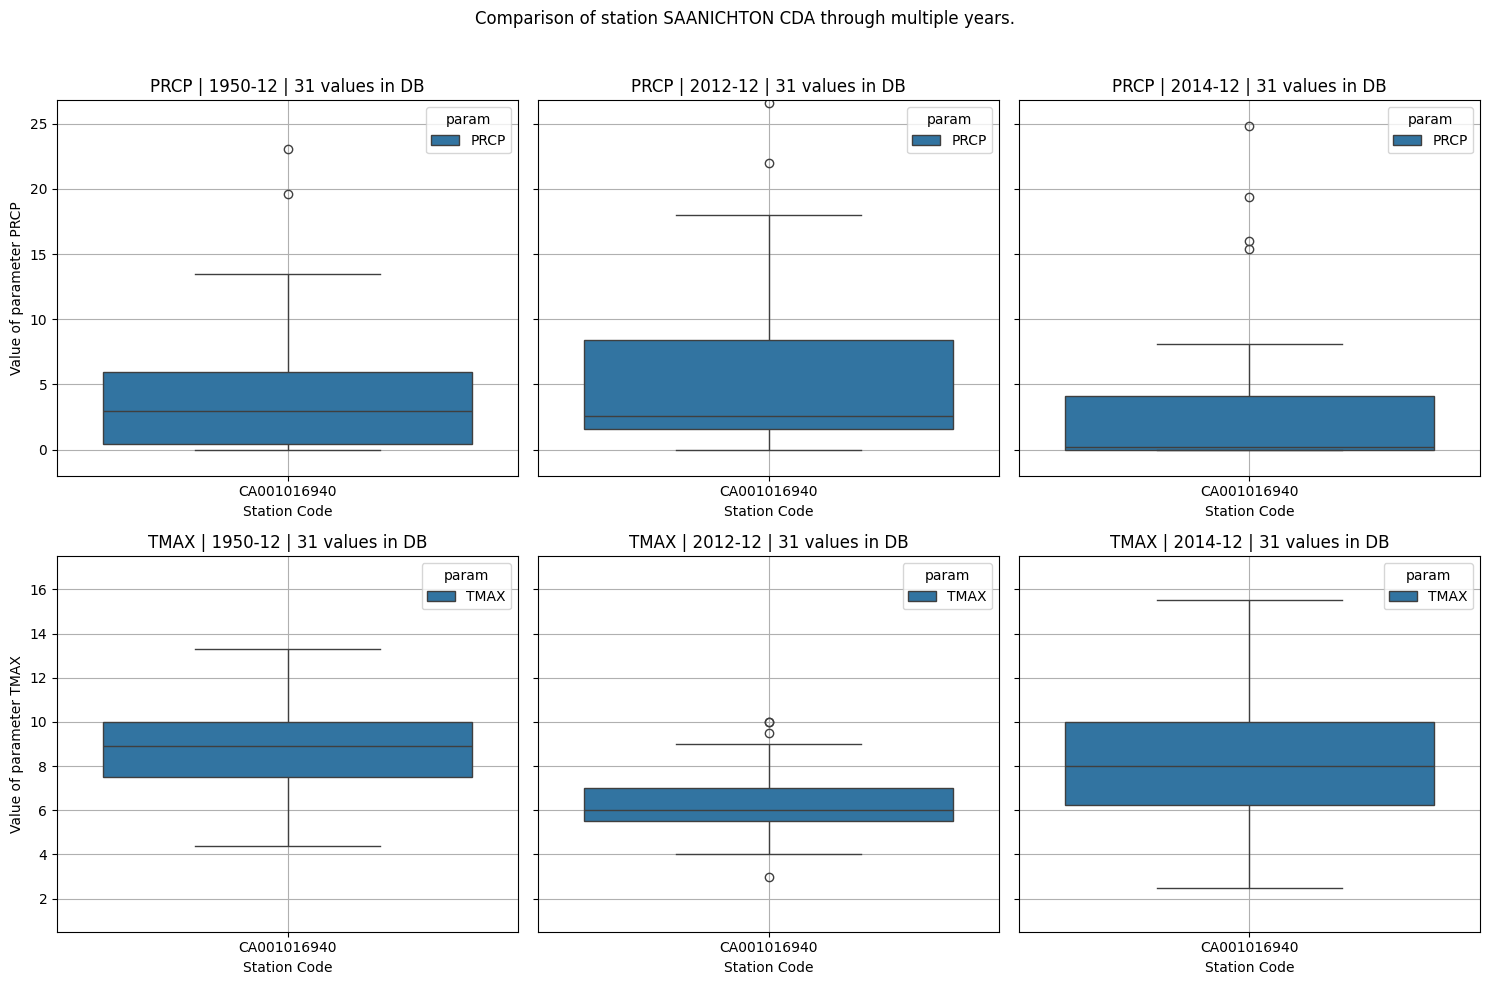

Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('ASN00008051') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 31 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('ASN00008051') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 31 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", 

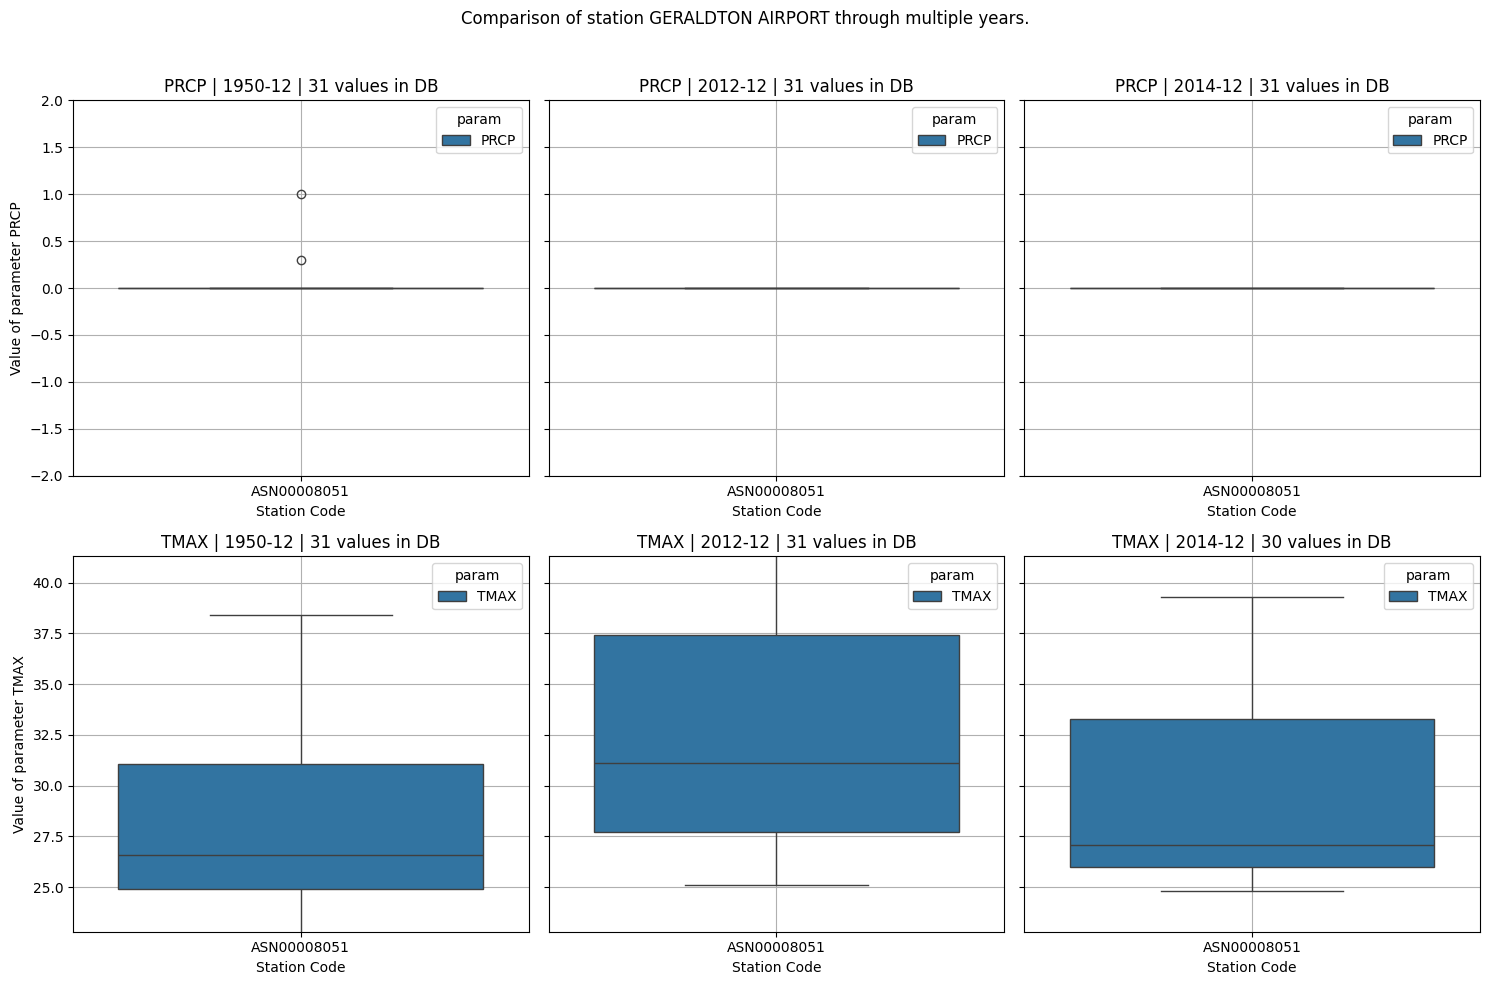

Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CHM00055279') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 0 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('CHM00055279') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 4 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "v

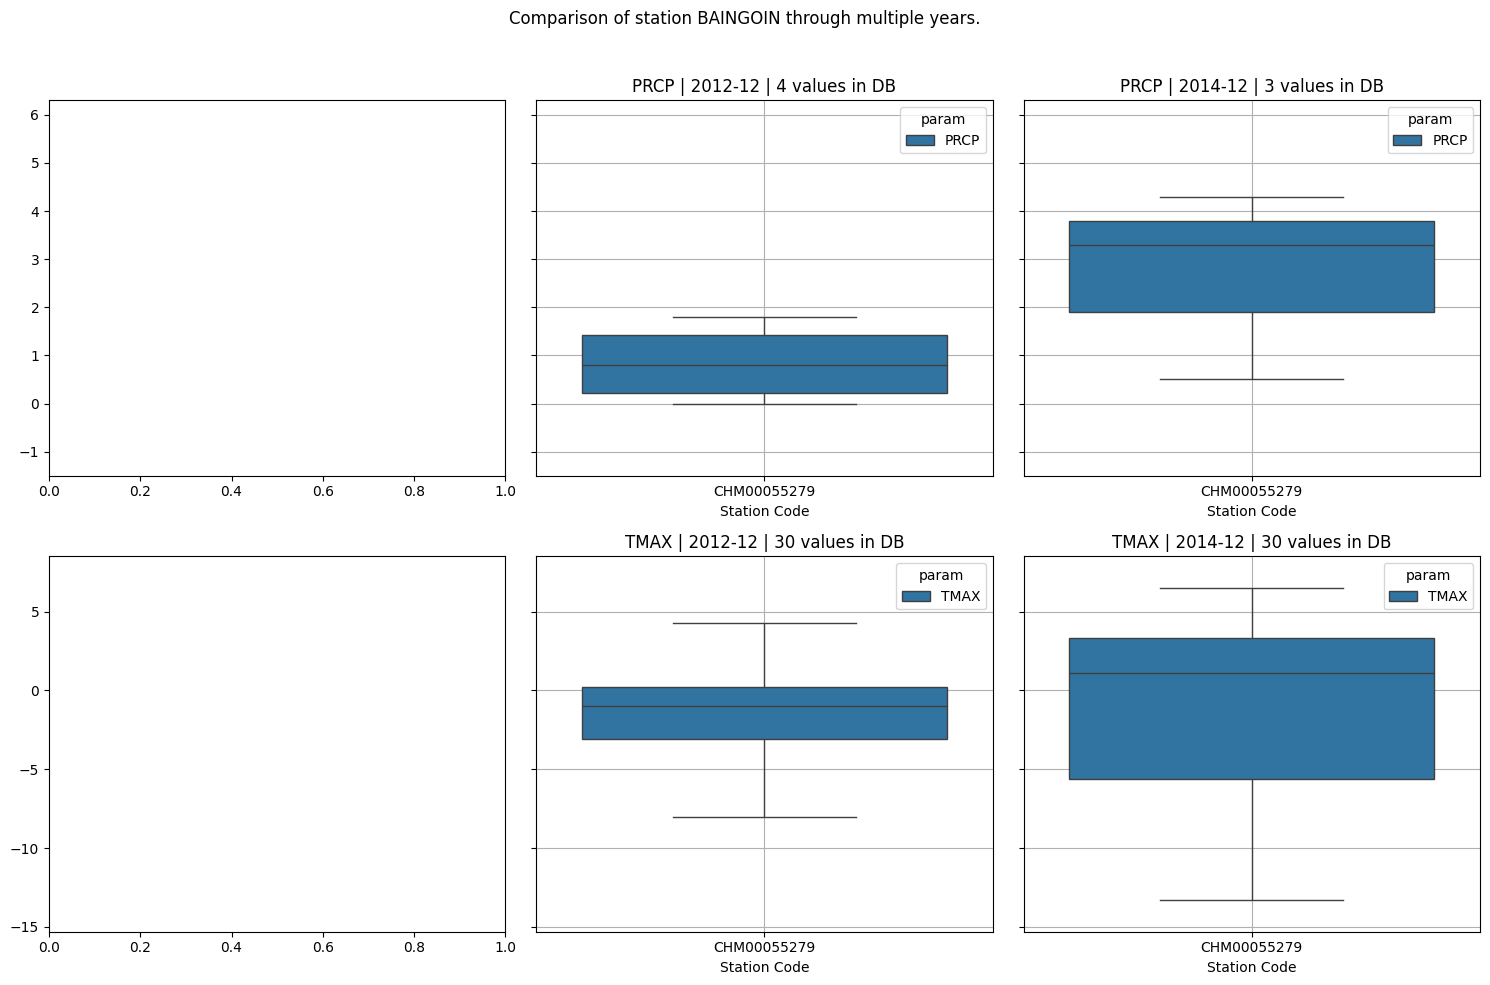

In [33]:
#create the boxplot visualization
create_boxplot_monthly_comparison(years_for_plotting, month, stations, parameters)

#### 9.1.4 Geographical plots

In [34]:
daily_data = ncei_db.get_data_yearly(years=[1950, 2010, 2014], parameters=[parameters[0]], stations=stations, columns=columns)

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP')
                    ORDER BY datelabel                
            
The requested query returned 1095 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2010"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP')
                    ORDER BY datelabel                
            
The requested query returned 1239 results.
Co

In [35]:
stations_df = pd.DataFrame(stations_data)
daily_df = pd.DataFrame(daily_data)

# Rename the 'id' column in the station data to match the 'station_id' in daily data
stations_df.rename(columns={"id": "stationcode"}, inplace=True)

# Merge the daily data with the station data on the station ID
merged_df = pd.merge(daily_df, stations_df, on="stationcode", how="left")

merged_df.head()

,stationcode,datelabel,value,param,latitude,longitude,elevation,state,name,gsn_flag,hcn_crn_flag,wmo_id
0,ASN00008051,1950-01-01,0.000000,PRCP,-28.7953,114.6975,33.0,None,GERALDTON AIRPORT,GSN,None,94403
1,CA001012040,1950-01-01,8.900001,PRCP,48.8167,-124.1333,177.0,BC,COWICHAN LAKE FORESTRY,None,None,None
2,CA001016940,1950-01-01,2.300000,PRCP,48.6167,-123.4167,61.0,BC,SAANICHTON CDA,None,None,None
3,ASN00008051,1950-01-02,0.000000,PRCP,-28.7953,114.6975,33.0,None,GERALDTON AIRPORT,GSN,None,94403
4,CA001012040,1950-01-02,0.000000,PRCP,48.8167,-124.1333,177.0,BC,COWICHAN LAKE FORESTRY,None,None,None


##### 9.1.4.1 Create first plot with geopandas

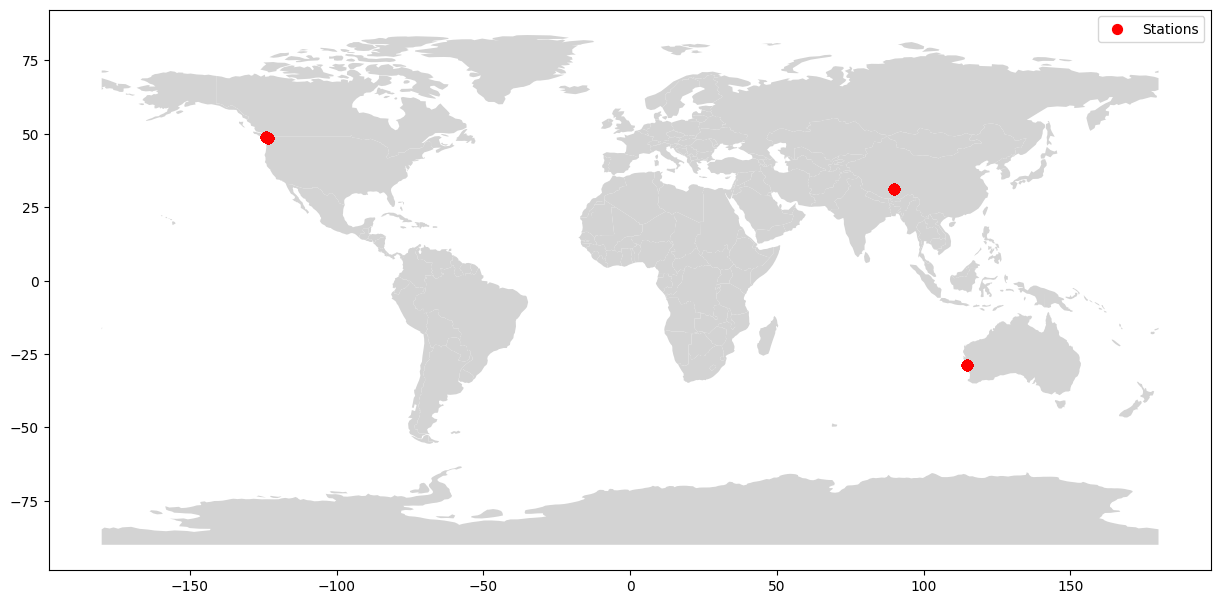

In [36]:
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(merged_df["longitude"], merged_df["latitude"])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry)

# Load the world map
world = gpd.read_file("./shapely_source_files/ne_110m_admin_0_countries.shp")

# Plot the data
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')

# Plotting the meteorological stations
gdf.plot(ax=ax, markersize=50, color='red', marker='o', label='Stations')

plt.legend()
plt.show()

##### 9.1.4.2 Create first plot with folium

In [37]:
# Create a folium map centered around the mean latitude and longitude of the stations
m = folium.Map(location=[merged_df["latitude"].mean(), merged_df["longitude"].mean()], zoom_start=2)

# we only want to plot each station once, this array stores the stationcodes of the already displayed stations
already_plotted = []

# Add markers for each station
for idx, row in merged_df.iterrows():
    if not row["stationcode"] in already_plotted:
        popup_content = f"""
        <div style="width: 200px; height: 150px;">
            <b>Station:</b> {row["name"]}<br>
            <b>Elevation:</b> {row["elevation"]}<br>
            <b>Longitude:</b> {row["longitude"]}<br>
            <b>Latitude:</b> {row["latitude"]}<br>
            <b>Example Value:</b> {row["value"]}<br>
            <b>Parameter of example value:</b> {row["param"]}
            <b>Date of example value:</b> {row["datelabel"]}<br>
        </div>
        """
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=folium.Popup(popup_content, max_width=300),
            tooltip=row["name"]
        ).add_to(m)

        already_plotted.append(row["stationcode"])
    
    

# Save the map to an HTML file
# m.save("stations_map.html")

m

##### 9.1.4.3 Plot yearly averages of stations 

In [38]:
daily_data = ncei_db.get_data_yearly(years=[1950], parameters=parameters, stations=stations, columns=columns)

stations_df = pd.DataFrame(stations_data)
daily_df = pd.DataFrame(daily_data)

# Rename the 'id' column in the station data to match the 'station_id' in daily data
stations_df.rename(columns={"id": "stationcode"}, inplace=True)

# Merge the daily data with the station data on the station ID
merged_df = pd.merge(daily_df, stations_df, on="stationcode", how="left")

merged_df.head()

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP','TMAX')
                    ORDER BY datelabel                
            
The requested query returned 2190 results.


,stationcode,datelabel,value,param,latitude,longitude,elevation,state,name,gsn_flag,hcn_crn_flag,wmo_id
0,ASN00008051,1950-01-01,43.200000,TMAX,-28.7953,114.6975,33.0,None,GERALDTON AIRPORT,GSN,None,94403
1,ASN00008051,1950-01-01,0.000000,PRCP,-28.7953,114.6975,33.0,None,GERALDTON AIRPORT,GSN,None,94403
2,CA001012040,1950-01-01,-2.200000,TMAX,48.8167,-124.1333,177.0,BC,COWICHAN LAKE FORESTRY,None,None,None
3,CA001012040,1950-01-01,8.900001,PRCP,48.8167,-124.1333,177.0,BC,COWICHAN LAKE FORESTRY,None,None,None
4,CA001016940,1950-01-01,-0.600000,TMAX,48.6167,-123.4167,61.0,BC,SAANICHTON CDA,None,None,None


In [39]:
merged_df.head()

,stationcode,datelabel,value,param,latitude,longitude,elevation,state,name,gsn_flag,hcn_crn_flag,wmo_id
0,ASN00008051,1950-01-01,43.200000,TMAX,-28.7953,114.6975,33.0,None,GERALDTON AIRPORT,GSN,None,94403
1,ASN00008051,1950-01-01,0.000000,PRCP,-28.7953,114.6975,33.0,None,GERALDTON AIRPORT,GSN,None,94403
2,CA001012040,1950-01-01,-2.200000,TMAX,48.8167,-124.1333,177.0,BC,COWICHAN LAKE FORESTRY,None,None,None
3,CA001012040,1950-01-01,8.900001,PRCP,48.8167,-124.1333,177.0,BC,COWICHAN LAKE FORESTRY,None,None,None
4,CA001016940,1950-01-01,-0.600000,TMAX,48.6167,-123.4167,61.0,BC,SAANICHTON CDA,None,None,None


In [40]:
# Create a folium map centered around the mean latitude and longitude of the stations
m = folium.Map(location=[merged_df["latitude"].mean(), merged_df["longitude"].mean()], zoom_start=2)

# we only want to plot each station once, this array stores the stationcodes of the already displayed stations
already_plotted = []

# Convert the "datelabel" column to datetime
merged_df["datelabel"] = pd.to_datetime(merged_df["datelabel"])

# Extract year from "datelabel"
merged_df["year"] = merged_df["datelabel"].dt.year

grouped_df = merged_df.groupby(["stationcode", "year", "param", "elevation", "longitude", "latitude", "name"]).agg({
    "value": "mean",
}).reset_index()

# Add markers for each station
for idx, row in grouped_df.iterrows():
    if not row["stationcode"] in already_plotted:
        filtered_df = grouped_df[(grouped_df["stationcode"] == row["stationcode"]) & (grouped_df["year"] == row["year"])]

        values = ""

        for grouped_idx, grouped_row in filtered_df.iterrows():
            values = values+f"""
                            <b>Value:</b> {grouped_row["value"]}<br>
                            <b>Parameter:</b> {grouped_row["param"]}<br>
                            <b>Year:</b> {grouped_row["year"]}<br>
                            """

        popup_content = f"""
        <div style="width: 200px; height: 150px;">
            <b>Station:</b> {row["name"]}<br>
            <b>Elevation:</b> {row["elevation"]}<br>
            <b>Longitude:</b> {row["longitude"]}<br>
            <b>Latitude:</b> {row["latitude"]}<br>
            {values}<br>
        </div>
        """
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=folium.Popup(popup_content, max_width=300),
            tooltip=row["name"]
        ).add_to(m)

        already_plotted.append(row["stationcode"])

m